In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tweepy as tw
from datetime import date
from langdetect import detect
import config

In [2]:
# Authenticate
client = tw.Client(config.bearer_token, config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
auth = tw.OAuth1UserHandler(config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
api = tw.API(auth)

### Get tweets

In [3]:
keyword = '#SP500 -is:retweet lang:en'
query = tw.Paginator(client.search_recent_tweets, query=keyword,
                              tweet_fields=['text', 'created_at'], max_results=100).flatten(limit=1000)
tweets = [{'Tweets':tweet.text, 'Timestamp':tweet.created_at.date()} for tweet in query]

In [4]:
df = pd.DataFrame.from_dict(tweets)
df.head()

,Tweets,Timestamp
0,Best options fill prices &amp; avoid options f...,2022-06-18
1,@markets Omen for Monday markets?\n\n(It has b...,2022-06-18
2,@DeItaone I have made a group for those trader...,2022-06-18
3,Get the best options fill prices &amp; avoid w...,2022-06-18
4,"I'm at the bottom, I'm at the end (I'm depress...",2022-06-18


In [5]:
df.shape

(1000, 2)

In [6]:
#recession_refs = ['Recession', 'recession', 'crisis', 'sell', 'sold']
#opportunity_refs = ['buy', 'opportunity', 'discount', 'plus']
#def identify_subject(tweet, refs):
#    flag = 0
#    for ref in refs:
#        if tweet.find(ref) !=-1:
#                flag = 1
#    return flag

#df['recession'] = df['Tweets'].apply(lambda x: identify_subject(x, recession_refs))
#df['opportunity'] = df['Tweets'].apply(lambda x: identify_subject(x, opportunity_refs))

### Preprocess

In [7]:
import nltk
from nltk.corpus import stopwords

from textblob import Word, TextBlob

In [8]:
#nltk.download('stopwords')
#nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['RT']

In [9]:
def preprocess_tweets(tweet, custom_stopwords):
    preprocessed_tweet = tweet
    preprocessed_tweet.replace('[@+:^\w\s]', '')
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in custom_stopwords)
    preprocessed_tweet = " ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return preprocessed_tweet
    
df['Processed_Tweet'] = df['Tweets'].apply(lambda x: preprocess_tweets(x, custom_stopwords)) 
df.head()

,Tweets,Timestamp,Processed_Tweet
0,Best options fill prices &amp; avoid options f...,2022-06-18,Best option fill price &amp; avoid option fill...
1,@markets Omen for Monday markets?\n\n(It has b...,2022-06-18,@markets Omen Monday markets? (It been.) 👀 #st...
2,@DeItaone I have made a group for those trader...,2022-06-18,@DeItaone I made group trader's looking trial ...
3,Get the best options fill prices &amp; avoid w...,2022-06-18,Get best option fill price &amp; avoid wide Bi...
4,"I'm at the bottom, I'm at the end (I'm depress...",2022-06-18,"I'm bottom, I'm end (I'm depressed) 😎 #Bitcoin..."


### Calculate sentiment

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj= SentimentIntensityAnalyzer()

In [11]:
df['polarity'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['polarity_vader'] = df['Processed_Tweet'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
df['subjectivity'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [12]:
df.head()

,Tweets,Timestamp,Processed_Tweet,polarity,polarity_vader,subjectivity
0,Best options fill prices &amp; avoid options f...,2022-06-18,Best option fill price &amp; avoid option fill...,0.538095,0.6705,0.514286
1,@markets Omen for Monday markets?\n\n(It has b...,2022-06-18,@markets Omen Monday markets? (It been.) 👀 #st...,0.000000,0.0000,0.000000
2,@DeItaone I have made a group for those trader...,2022-06-18,@DeItaone I made group trader's looking trial ...,0.000000,0.0000,0.000000
3,Get the best options fill prices &amp; avoid w...,2022-06-18,Get best option fill price &amp; avoid wide Bi...,0.371429,0.5423,0.447619
4,"I'm at the bottom, I'm at the end (I'm depress...",2022-06-18,"I'm bottom, I'm end (I'm depressed) 😎 #Bitcoin...",0.000000,-0.0772,0.000000


### Visualize

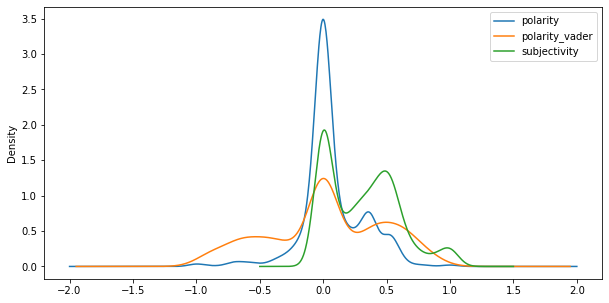

In [13]:
df.plot(figsize=(10,5), kind='density', legend=True);

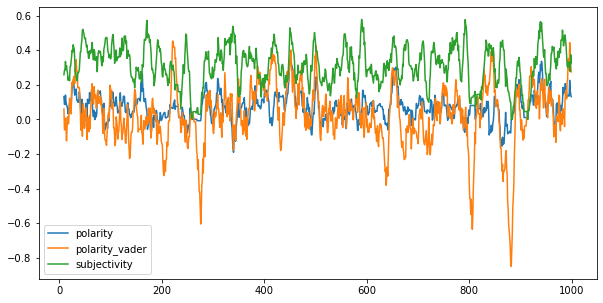

In [14]:
df.polarity.rolling(10).mean().plot(legend=True, figsize=(10,5));
df.polarity_vader.rolling(10).mean().plot(legend=True, figsize=(10,5));
df.subjectivity.rolling(10).mean().plot(legend=True, figsize=(10,5));

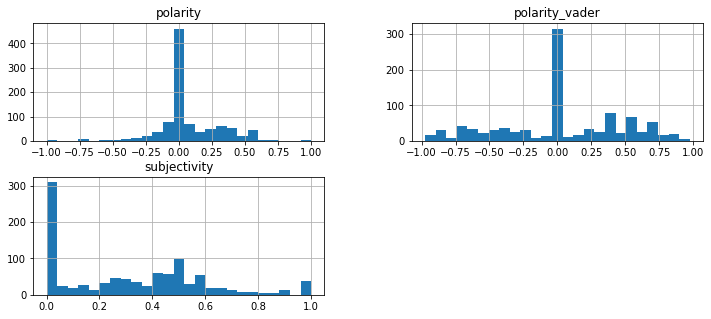

In [15]:
df.hist(bins=25, figsize=(12,5));

In [16]:
df.describe()

,polarity,polarity_vader,subjectivity
count,1000.000000,1000.000000,1000.000000
mean,0.070029,0.027194,0.311679
std,0.244104,0.454633,0.282611
min,-1.000000,-0.974300,0.000000
25%,0.000000,-0.278900,0.000000
50%,0.000000,0.000000,0.300000
75%,0.173750,0.401900,0.514286
max,1.000000,0.973000,1.000000


In [17]:
df[df.polarity==0].count()

Tweets             413
Timestamp          413
Processed_Tweet    413
polarity           413
polarity_vader     413
subjectivity       413
dtype: int64

In [18]:
df[df.polarity_vader==0].count()

Tweets             305
Timestamp          305
Processed_Tweet    305
polarity           305
polarity_vader     305
subjectivity       305
dtype: int64

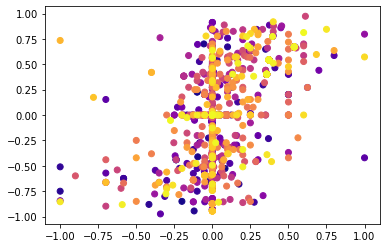

In [19]:
colors = np.array(np.arange(0, 1000))
plt.scatter(x=df.polarity, y=df.polarity_vader, c=colors, cmap='plasma');

### Analizying tweets with Bert

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [21]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [22]:
def bert_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [23]:
df['polarity_bert'] = df['Processed_Tweet'].apply(lambda x: bert_score(x[:512]))
df['polarity_bert'] = -1+ 0.5* (df['polarity_bert']-1)

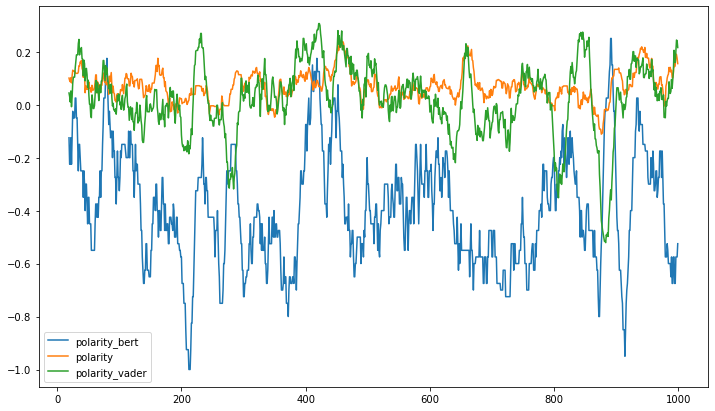

In [25]:
df.polarity_bert.rolling(20).mean().plot(legend=True, figsize=(12,7));
df.polarity.rolling(20).mean().plot(legend=True, figsize=(12,7));
df.polarity_vader.rolling(20).mean().plot(legend=True, figsize=(12,7));

In [26]:
df.describe()

,polarity,polarity_vader,subjectivity,polarity_bert
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.070029,0.027194,0.311679,-0.390500
std,0.244104,0.454633,0.282611,0.844081
min,-1.000000,-0.974300,0.000000,-1.000000
25%,0.000000,-0.278900,0.000000,-1.000000
50%,0.000000,0.000000,0.300000,-1.000000
75%,0.173750,0.401900,0.514286,0.500000
max,1.000000,0.973000,1.000000,1.000000


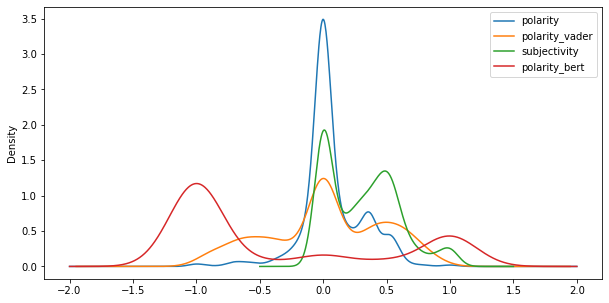

In [27]:
df.plot(figsize=(10,5), kind='density', legend=True);